In [1]:
import gym
import time
import numpy as np
import random
from matplotlib import pyplot as plt

In [45]:
env = gym.make("MountainCar-v0", render_mode ="ansi")


In [31]:
state, info = env.reset()


In [32]:
state

array([-0.5915698,  0.       ], dtype=float32)

In [33]:
l_pos, l_vel = env.observation_space.low
h_pos, h_vel = env.observation_space.high

In [34]:
POS_PONT = 100
VEL_POINT = 100

In [35]:
pos_range = np.linspace(l_pos, h_pos,POS_PONT)
vel_range = np.linspace(l_vel, h_vel,VEL_POINT)

In [36]:
def discretize_velocity(velocity):
    # Discretize state
    index = np.argmin(np.abs(vel_range - velocity))
    return index

def discretize_position(position):
    # Discretize state
    index = np.argmin(np.abs(pos_range - position))
    return index

In [37]:
qtable = np.zeros((len(pos_range), len(vel_range), env.action_space.n))
qtable.shape

(100, 100, 3)

In [46]:
achieve_steps = []

In [47]:
def QLearning(env, learning, discount, epsilon, max_steps, episodes):
    

    for i in range(episodes):
        print("Episodes n°:", i)
        state, info = env.reset()
        done = False
        decay_rate= 0.005


        #state_dis = (state - env.observation_space.low)*np.array([10, 100])
        #state_dis = np.round(state_dis, 0).astype(int)

        state_dis = [discretize_position(state[0]), discretize_velocity(state[1])]


        for j in range(max_steps):

            if random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(qtable[state_dis[0], state_dis[1]])

            new_state, reward, done, truncated, info = env.step(action)

            #new_state_dis = (new_state - env.observation_space.low)*np.array([10, 100])
            #new_state_dis = np.round(new_state_dis, 0).astype(int)

            new_state_dis = [discretize_position(new_state[0]), discretize_velocity(new_state[1])]


            if done == True or new_state[0] > 0.5:
                qtable[state_dis[0], state_dis[1], action] = reward
                print("Sucessful")
                break
            
            qtable[state_dis[0], state_dis[1], action] = qtable[state_dis[0], state_dis[1], action] + learning * (reward + discount * np.max(qtable[new_state_dis[0], new_state_dis[1]])-qtable[state_dis[0], state_dis[1], action])

            state_dis = new_state_dis
        achieve_steps.append(j)

            

            
        epsilon = np.exp(-decay_rate*i)

In [48]:
QLearning(env, 0.9, 0.8, 1.0, 500, 10000)

Episodes n°: 0
Episodes n°: 1
Episodes n°: 2
Episodes n°: 3
Episodes n°: 4
Episodes n°: 5
Episodes n°: 6
Episodes n°: 7
Episodes n°: 8
Episodes n°: 9
Episodes n°: 10
Episodes n°: 11
Episodes n°: 12
Episodes n°: 13
Episodes n°: 14
Episodes n°: 15
Episodes n°: 16
Episodes n°: 17
Episodes n°: 18
Episodes n°: 19
Episodes n°: 20
Episodes n°: 21
Episodes n°: 22
Episodes n°: 23
Episodes n°: 24
Episodes n°: 25
Episodes n°: 26
Episodes n°: 27
Episodes n°: 28
Episodes n°: 29
Episodes n°: 30
Episodes n°: 31
Episodes n°: 32
Episodes n°: 33
Episodes n°: 34
Episodes n°: 35
Episodes n°: 36
Episodes n°: 37
Episodes n°: 38
Episodes n°: 39
Episodes n°: 40
Episodes n°: 41
Episodes n°: 42
Episodes n°: 43
Episodes n°: 44
Episodes n°: 45
Episodes n°: 46
Episodes n°: 47
Episodes n°: 48
Episodes n°: 49
Episodes n°: 50
Episodes n°: 51
Episodes n°: 52
Episodes n°: 53
Episodes n°: 54
Episodes n°: 55
Episodes n°: 56
Episodes n°: 57
Episodes n°: 58
Episodes n°: 59
Episodes n°: 60
Episodes n°: 61
Episodes n°: 62
Ep

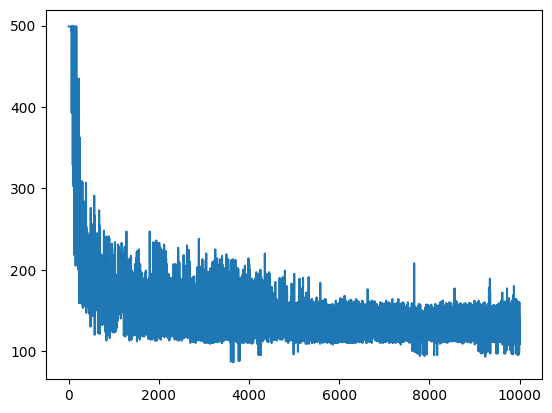

In [49]:
plt.plot(achieve_steps)

In [50]:
import imageio
import pyglet
from pyglet.window import key

In [57]:
env.close()
env = gym.make("MountainCar-v0", render_mode ="rgb_array")

state,info = env.reset()

state_dis = [discretize_position(state[0]), discretize_velocity(state[1])]


images = []

while 1>0:

    action = np.argmax(qtable[state_dis[0],state_dis[1]])
    new_state, reward, done, trunc, info = env.step(action)
    frame = env.render()  # Save the frame
    images.append(frame)

    new_state_dis = [discretize_position(new_state[0]), discretize_velocity(new_state[1])]

    state_dis = new_state_dis
    if done == True:
        break

env.close()
imageio.mimsave('output.gif', images, fps=30)